In [ ]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll
!pip install musicautobot
!pip install midi2audio

Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6 MB 3.6 MB/s 
     |████████████████████████████████| 51 kB 7.7 MB/s 


In [ ]:
import torch
import os
import json
import pandas as pd
import numpy as np
import pypianoroll
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from music21 import *
from musicautobot.numpy_encode import *
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.utils import midifile
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# root_dir = 'drive/MyDrive/Pianorolls'
# data_dir = root_dir + '/lpd/lpd_cleansed'
# music_dataset_lpd_dir = root_dir + '/lpd/lpd_cleansed'
# combined_pianorolls = torch.load(os.path.join(root_dir, 'pianorolls.pt'))
# pianoroll_lengths = torch.load(os.path.join(root_dir, 'pianorolls_lengths.pt'))

root_dir = 'drive/MyDrive/Deep Learning Project'
combined_pianorolls = torch.load(os.path.join(root_dir, 'Pianorolls', 'pianorolls.pt'))
pianoroll_lengths = torch.load(os.path.join(root_dir, 'Pianorolls', 'pianorolls_lengths.pt'))

In [ ]:
# Explore data, tensors
data = combined_pianorolls
data = data[0][100]
print(len(combined_pianorolls))
print(combined_pianorolls[0].size())
number_of_characters = len(data)

line_length = 4 #length of sequence (1-25)

def get_seq(i,lim):
  start = i - line_length#random.randint(0,number_of_characters - 25)
  if start < 0:
    start = 0

  seq = []

  togo = abs(start - i)
  for x in range(0,togo):
    seq.append(data[start+x])

  return seq

print('Number of characters in file :', number_of_characters)

chars = []
bigset = set(chars)
combined_pianorolls_list = []

print(combined_pianorolls[0][0])


comb_index = np.zeros((len(combined_pianorolls), 617,1))

for iii in range(617):
  for ii in range(128):
    testn = combined_pianorolls[iii][ii].tolist()
    for i in range(len(combined_pianorolls[iii][ii])):
      if testn[len(combined_pianorolls[iii][ii]) - 1 - i] > 0:
        comb_index[iii][ii] = i

#print(comb_index[0][0])
print(len(combined_pianorolls),len(comb_index))
print(len(combined_pianorolls[0]),len(comb_index[0]))
print(len(combined_pianorolls[0][0]),len(comb_index[0][0]))

print(len(set(combined_pianorolls[0])), "vs", (len(combined_pianorolls[0])+len(combined_pianorolls[1])+len(combined_pianorolls[2])))

data = combined_pianorolls[0].tolist()

notelist = range(128)
all_chars = set(notelist)#bigset#set(data)
m = len(set(notelist))#len(set(data))
n_letters = m
all_letters = list(all_chars)

print(m)

1163
torch.Size([617, 128])
Number of characters in file : 128
tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 100,   0, 127,   0,   0,   0,   0, 127,   0, 127,
          0, 127,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0], dtype=torch.uint8)
1163 1163
617 617
128 1
617 vs 2625
128


In [ ]:
import torch

all_chars_list = list(all_chars)
#print(n_letters)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    out = next((i for i, x in enumerate(all_chars_list) if x == letter), 0)
    return out#all_chars.find(letter)

def noteToIndex(letter):
    out = next((i for i, x in enumerate(all_chars_list) if x == letter), 0)
    return out#all_chars.find(letter)

def TensorToIndex(letter):
    out = next((i for i, x in enumerate(all_chars_list) if torch.equal(x,letter)), 0)
    return out#all_chars.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def TensorToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][TensorToIndex(letter)] = 1
    return tensor

def noteToTensor(note):
    tensor = tensor_set[noteToIndex(note)]
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def BarToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li]= noteToTensor(letter)
    return tensor

#print(letterToTensor('K'))

#print(lineToTensor('Jones').size())
#print(BarToTensor(combined_pianorolls[0][0:5].tolist()).size())
print(letterToTensor(126))
print(lineToTensor([0,1,120,0]))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]])
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 1
rnn = RNN(n_letters, n_hidden, n_letters)

In [ ]:
input = letterToTensor(0)
#tensor = torch.zeros(1,128)
#tensor[0] = combined_pianorolls[0][0]
#inpp = torch.stack((emp,combined_pianorolls[0][0]),1)
#input = tensor#torch.tensor(combined_pianorolls[0][0])#noteToTensor(all_chars_list[1])
print(input)
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


In [ ]:
input = lineToTensor([0,0,3,20])
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-4.8590, -4.9349, -4.7634, -4.9510, -4.8875, -4.8673, -4.8896, -4.8642,
         -4.9213, -4.7518, -4.8486, -4.9489, -4.8460, -4.7461, -4.8487, -4.7982,
         -4.9144, -4.9948, -4.9630, -4.8077, -4.7169, -4.7779, -4.8780, -4.7139,
         -4.9350, -4.7990, -4.8602, -4.9175, -4.8900, -4.9136, -4.8939, -4.7634,
         -4.8307, -4.8155, -4.8844, -4.9487, -4.9425, -4.8070, -4.7109, -4.8701,
         -4.8535, -4.8629, -4.9262, -4.7333, -4.7901, -4.8185, -4.9160, -4.8033,
         -4.9670, -4.7669, -4.9272, -4.9426, -4.7777, -4.7705, -4.8439, -4.7523,
         -4.8239, -4.9037, -4.8687, -4.9340, -4.7848, -4.8908, -4.8029, -4.9015,
         -4.8375, -4.8497, -4.9667, -4.8732, -4.8981, -4.9143, -4.8957, -4.7556,
         -4.8494, -4.8491, -4.7975, -4.7219, -4.9009, -4.8601, -4.8317, -4.8631,
         -4.8151, -4.8595, -4.9048, -4.6881, -4.8531, -4.8468, -4.8933, -4.8591,
         -4.8144, -4.9463, -4.9297, -4.8401, -4.8141, -4.8792, -4.8018, -4.8624,
         -4.9382, -4.8963, -

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_chars_list[category_i], category_i

print(categoryFromOutput(output))

(83, 83)


In [ ]:
mylist = ['a','b','c','b']
def lookallindicesof(char, list):
    indexlist = []
    for item in enumerate(list):
        if char in item:
            indexlist.append(item[0])
    return indexlist

indexlist = lookallindicesof('b',mylist)
print(indexlist)

data = comb_index.flatten()
data = data[0:len(data)//2]
print(len(data))
available_chars = set(data)
available_chars = list(available_chars)

[1, 3]
358785


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(available_chars)#all_chars_list)
    ind_c = -1
    chooselist = lookallindicesof(category,data)
    for ele in chooselist:
      if ele < line_length: #removes all indices smaller than line_length
        chooselist.remove(ele)
    ind_c = randomChoice(chooselist)
    line = get_seq(ind_c,number_of_characters)
    category_tensor = torch.tensor([all_chars_list.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = 96.0 / line = [91.0, 79.0, 79.0, 86.0]
category = 61.0 / line = [61.0, 61.0, 61.0, 61.0]
category = 35.0 / line = [36.0, 36.0, 36.0, 33.0]
category = 51.0 / line = [53.0, 55.0, 55.0, 51.0]
category = 35.0 / line = [36.0, 36.0, 36.0, 33.0]
category = 93.0 / line = [93.0, 93.0, 93.0, 93.0]
category = 93.0 / line = [93.0, 93.0, 93.0, 93.0]
category = 89.0 / line = [87.0, 89.0, 89.0, 89.0]
category = 71.0 / line = [71.0, 71.0, 71.0, 71.0]
category = 68.0 / line = [68.0, 68.0, 68.0, 68.0]


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 #0.001 # If you set this too high, it might explode. If too low, it might not learn
#Good: datasize:10000 lr = 0.01 iteration: 500000

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (11m 27s) 4.4138 [104.0, 104.0, 104.0, 104.0] / 104 ✓
10000 10% (22m 52s) 4.1207 [87.0, 86.0, 86.0, 86.0] / 86 ✓
15000 15% (34m 21s) 4.2624 [45.0, 43.0, 45.0, 47.0] / 47 ✗ (45.0)
20000 20% (45m 50s) 4.3572 [65.0, 0.0, 56.0, 56.0] / 70 ✗ (56.0)
25000 25% (57m 4s) 2.6941 [46.0, 46.0, 46.0, 46.0] / 46 ✓
30000 30% (68m 31s) 3.2074 [51.0, 51.0, 51.0, 51.0] / 51 ✓
35000 35% (80m 5s) 1.9372 [99.0, 101.0, 101.0, 101.0] / 101 ✓
40000 40% (91m 37s) 2.5267 [0.0, 0.0, 0.0, 0.0] / 0 ✓
45000 45% (103m 7s) 2.4852 [62.0, 50.0, 50.0, 44.0] / 44 ✓
50000 50% (114m 40s) 2.8413 [36.0, 36.0, 36.0, 33.0] / 33 ✗ (35.0)
55000 55% (125m 56s) 4.4724 [33.0, 33.0, 33.0, 33.0] / 33 ✗ (30.0)
60000 60% (137m 17s) 1.8200 [60.0, 60.0, 60.0, 60.0] / 60 ✓
65000 65% (148m 36s) 1.7284 [53.0, 55.0, 55.0, 56.0] / 56 ✓
70000 70% (159m 58s) 1.6382 [70.0, 70.0, 77.0, 77.0] / 77 ✓
75000 75% (171m 23s) 1.4721 [47.0, 45.0, 47.0, 45.0] / 45 ✓
80000 80% (182m 53s) 1.2497 [39.0, 39.0, 39.0, 39.0] / 39 ✓
85000 85% (194m 19s) 2

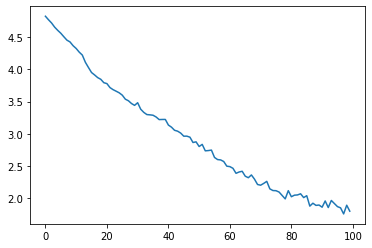

In [ ]:
plt.figure()
plt.plot(all_losses)

Load model from previous training

In [ ]:
torch.save(rnn.state_dict(), os.path.join(root_dir, 'malakhi_weights.pth'))
rnn.load_state_dict(torch.load(os.path.join(root_dir, 'malakhi_weights.pth')))

NameError: ignored

OG:  [39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0]
FIN:  [39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 83, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38]
OG:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
FIN:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 83, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38]
OG:  [81.0, 81.0, 89.0, 89.0, 88.0, 88.0, 88.0, 93.0, 93.0, 93.0, 93.0, 93.0, 91.0, 91.0, 96.0]
FIN:  [81.0, 81.0, 89.0, 89.0, 88.0, 88.0, 88.0, 93.0, 93.0, 93.0, 93.0, 93.0, 91.0, 91.0, 96.0, 62, 62, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13]
OG:  [61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 0.0, 61.0, 92.0, 92.0]
FIN:  [61.0, 61.0, 61.0, 61.0, 61.0, 61.0, 6

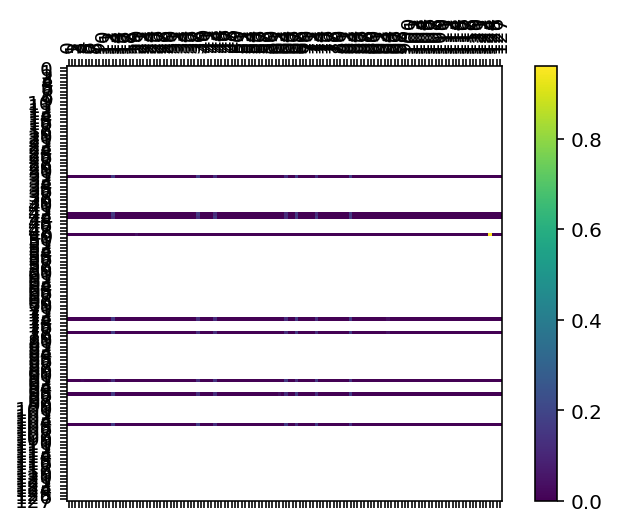

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_letters, n_letters)
n_confusion = 10

line_length = 15
OUTPUT_LENGTH = 25

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
# OUTPUT LOOP!:
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    bigline = line ## MM
    if (i < 1000): #limits the output to range of steps
      print("OG: ", line)
    for ii in range(OUTPUT_LENGTH): #MM - this for loop makes it X TO MANY instead of X to ONE. Erase for for loop and anything with MM to make X to ONE
      line_tensor = lineToTensor(line)
      output = evaluate(line_tensor)
      guess, guess_i = categoryFromOutput(output) # GUESS IS ACTUAL NOTE RNN PREDICTS
      category_i = all_chars_list.index(category)
      confusion[category_i][guess_i] += 1
      line.append(int(guess))#guess # MM
      #print(line)
      bigline.append(int(guess))#+= guess ## MM
      line = line[1:] # MM - shorten line to proper size ###### ars2
    if (i < 1000):  #limits the output to range of steps
      print("FIN: ", bigline) # MM


# Normalize by dividing every row by its sum
for i in range(n_letters):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_chars_list, rotation=90)
ax.set_yticklabels([''] + all_chars_list)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
line_length = 10
OUTPUT_LENGTH = 30

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    bigline = line ## MM
    if (i < 1000): #limits the output to range of steps
      print("OG: ", line)
    for ii in range(OUTPUT_LENGTH): #MM - this for loop makes it X TO MANY instead of X to ONE. Erase for for loop and anything with MM to make X to ONE
      line_tensor = lineToTensor(line)
      output = evaluate(line_tensor)
      guess, guess_i = categoryFromOutput(output) # GUESS IS ACTUAL NOTE RNN PREDICTS
      category_i = all_chars_list.index(category)
      confusion[category_i][guess_i] += 1
      line.append(int(guess))#guess # MM
      #print(line)
      bigline.append(int(guess))#+= guess ## MM
      line = line[1:] # MM - shorten line to proper size ###### ars2
    if (i < 1000):  #limits the output to range of steps
      print("FIN: ", bigline) # MM

OG:  [38.0, 31.0, 31.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 33.0]
FIN:  [38.0, 31.0, 31.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 33.0, 73, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43]
OG:  [73.0, 73.0, 73.0, 73.0, 69.0, 69.0, 69.0, 73.0, 73.0, 73.0]
FIN:  [73.0, 73.0, 73.0, 73.0, 69.0, 69.0, 69.0, 73.0, 73.0, 73.0, 43, 43, 62, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43]
OG:  [81.0, 67.0, 67.0, 0.0, 0.0, 81.0, 81.0, 0.0, 0.0, 69.0]
FIN:  [81.0, 67.0, 67.0, 0.0, 0.0, 81.0, 81.0, 0.0, 0.0, 69.0, 94, 94, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83]
OG:  [79.0, 86.0, 86.0, 86.0, 86.0, 86.0, 88.0, 88.0, 88.0, 88.0]
FIN:  [79.0, 86.0, 86.0, 86.0, 86.0, 86.0, 88.0, 88.0, 88.0, 88.0, 83, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 64, 73, 43, 83, 67, 13, 38, 

#Converting output data to MIDI/Audio

In [ ]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.3

    midi_stream = stream.Stream(output_notes)

    return midi_stream

In [ ]:
generated_path = os.path.join(root_dir, 'Generated MIDIs', 'midiname.mid')
generated_stream = create_midi(bigline)
generated_stream.write('midi', fp=generated_path)

'drive/MyDrive/Deep Learning Project/Generated MIDIs/four.mid'

In [ ]:
# Load the generated MIDI
generated_multitrack = pypianoroll.read(generated_path)
generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)
generated_midi_audio = generated_pm.fluidsynth()
IPython.display.Audio(generated_midi_audio, rate = 44100)